In [1]:
%matplotlib inline
import ipywidgets as widgets
import gensim
import os
import matplotlib.pyplot as plt
import bidi.algorithm
import arabic_reshaper

## Word embedding model for arabic
This app allows you to find related words in a word embedding model for Arabic.

The current model is the Wikipedia CBOW model from [AraVec](https://github.com/bakrianoo/aravec), see: Abu Bakr Soliman, Kareem Eisa, and Samhaa R. El-Beltagy, “AraVec: A set of Arabic Word Embedding Models for use in Arabic NLP”, in proceedings of the 3rd International Conference on Arabic Computational Linguistics (ACLing 2017), Dubai, UAE, 2017.

In [2]:
model_path = 'data'

In [3]:
# To do: list multiple available models and only download them when needed
models = {}
filenames = os.listdir(model_path)
for fn in filenames:
    try:
        models[fn] = gensim.models.KeyedVectors.load(os.path.join(model_path, fn))
    except:
        pass

In [4]:
nicer_names_dict = {'wikipedia_cbow_100': 'Wikipedia',
                    'cbow-fiqh-100-wikipedia-finetuned-wv': 'Wikipedia+Fiqh',
                   'fiqh-i10-s100-w5-sg0_wv': 'Fiqh', 
                   'stemmed-fiqh-i10-s100-w5-sg0_wv': 'Stemmed Fiqh'}

In [5]:
models = {nicer_names_dict.get(model, model): models[model] for model in models}

In [6]:
def most_similar(word, model, topn=10):
    res = model.wv.most_similar(word, topn=topn)
    output = [u'{} \t{:.3f}'.format(w, s) for w, s in res]
    return '\n'.join(output)

In [99]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def plot_embedding(word_list, model, method='pca', learning_rate=60, colors=None):
    X = model[word_list]
    if method is 'pca':
        X_embedded = PCA(n_components=2).fit_transform(X)
    else:
        X_pre = PCA(n_components=30).fit_transform(X)
        X_embedded = TSNE(n_components=2, learning_rate=learning_rate, random_state=0).fit_transform(X_pre)

    plt.figure(figsize=(15,15))
    plt.scatter(X_embedded[:,0], X_embedded[:,1], c=colors)
    plt.axis('off')
    for i, w in enumerate(word_list):
        display_word = bidi.algorithm.get_display(arabic_reshaper.reshape(w))
        plt.annotate(display_word, xy=(X_embedded[i, 0], X_embedded[i, 1]), fontsize=20)
    plt.show()

In [75]:
def plot_closest_words(word, model, method='pca', topn=30, learning_rate=60, colors=None):
    word_list = [w for w, s in model.wv.most_similar(word, topn=topn)]
    word_list.append(word)
    plot_embedding(word_list, model, method, learning_rate, colors)

/home/dafne/anaconda2/envs/adh/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  from ipykernel import kernelapp as app


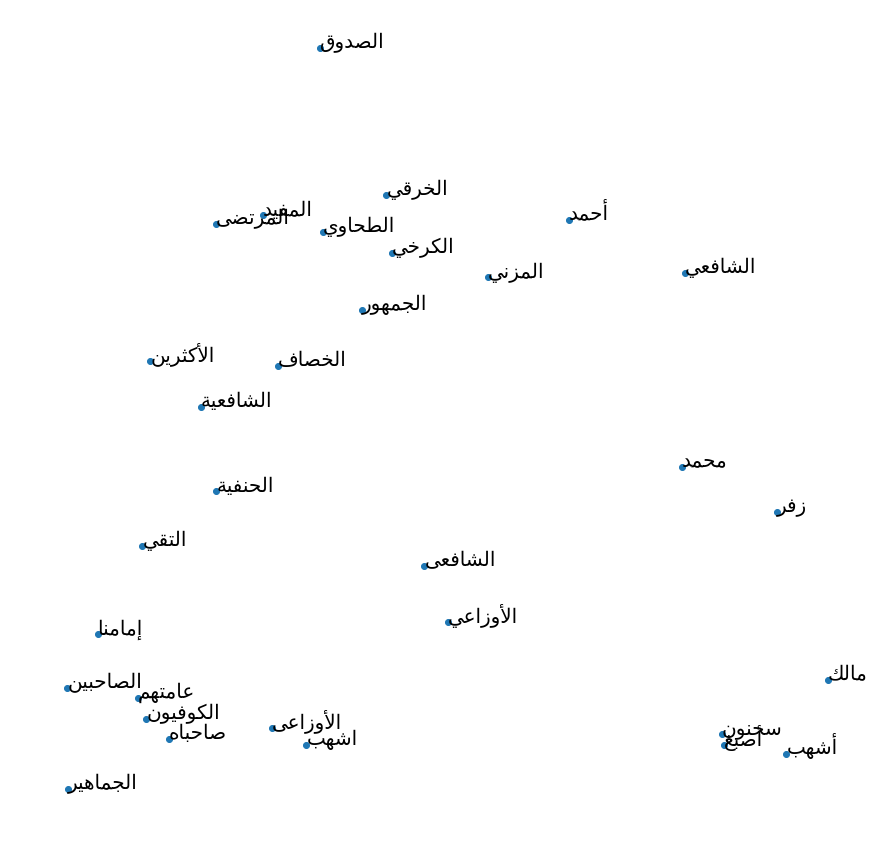

In [79]:
model = models['Fiqh']
word = 'الشافعي'
plot_closest_words(word, model, method='pca', topn=30)

In [107]:
import re
def get_pattern_from_root(root):
    return '.*'+ root[0] + '.*' + root[1] + '.*' + root[2]+'.*'


root1 = 'حلل'
root2 = 'حرم'
m1 = get_pattern_from_root(root1)
m2 = get_pattern_from_root(root2)
re.match(m1, word1), re.match(m2, word2)

(<_sre.SRE_Match object; span=(0, 4), match='حلال'>,
 <_sre.SRE_Match object; span=(0, 4), match='حرام'>)

In [108]:
word1 = 'حلال'
word2 = 'حرام'
model = models['Stemmed Fiqh']
#model = models['Fiqh']
n =  20
word_list = [word1] + [w for w, s in model.wv.most_similar(word1, topn=n)] \
  + [word2] + [w for w, s in model.wv.most_similar(word2, topn=n)]
word_list = list(set(word_list))
colors = ['grey']*len(word_list)
for i, w in enumerate(word_list):
    if re.match(m1, w) is not None:
        colors[i] = 'green'
    if re.match(m2, w) is not None:
        colors[i] = 'red'
list(zip(word_list, colors))

/home/dafne/anaconda2/envs/adh/lib/python3.6/site-packages/ipykernel/__main__.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


[('حلال', 'green'),
 ('حرمت', 'red'),
 ('فقليل', 'grey'),
 ('لحلال', 'green'),
 ('فحرام', 'red'),
 ('وصيد', 'grey'),
 ('مرتكب', 'grey'),
 ('وحلال', 'green'),
 ('محظور', 'grey'),
 ('لعين', 'grey'),
 ('حرام', 'red'),
 ('كالحلال', 'green'),
 ('كظهر', 'grey'),
 ('احل', 'grey'),
 ('تحريم', 'red'),
 ('حل', 'grey'),
 ('حرم', 'red'),
 ('فحلال', 'green'),
 ('استخبث', 'grey'),
 ('اصطاد', 'grey'),
 ('مباح', 'grey'),
 ('يحرم', 'red'),
 ('مكرو', 'grey'),
 ('محلل', 'green'),
 ('مسكر', 'grey'),
 ('اسكر', 'grey'),
 ('بحلال', 'green'),
 ('مستخبث', 'grey'),
 ('محرم', 'red'),
 ('وحرام', 'red')]

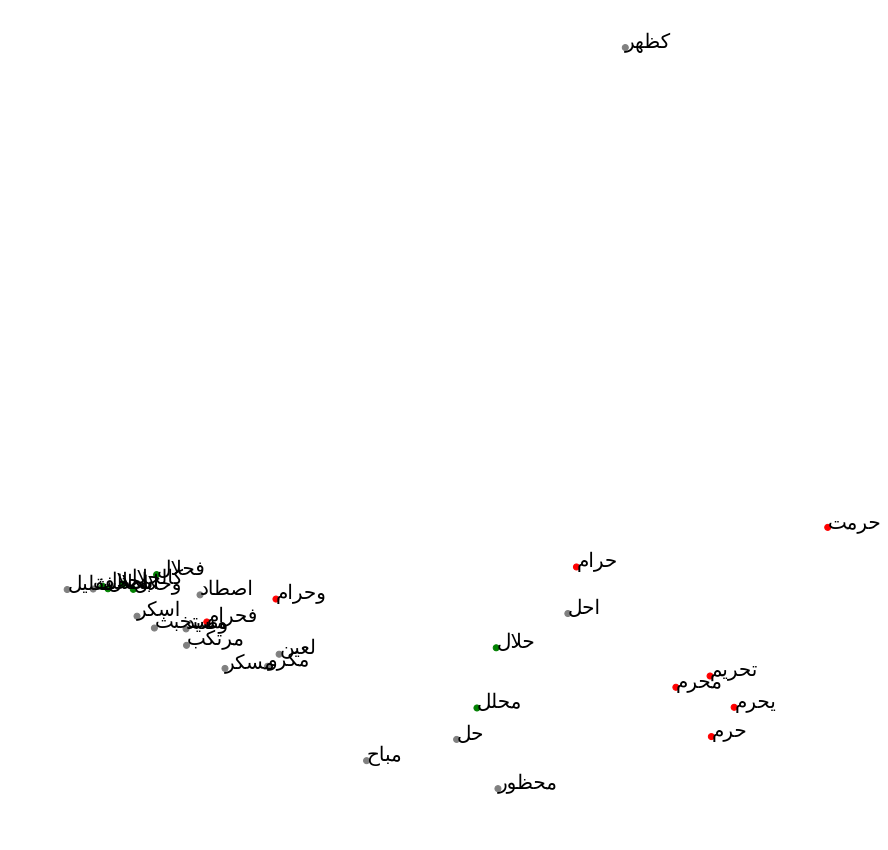

In [94]:
plot_embedding(word_list, model, method='pca', colors=colors)

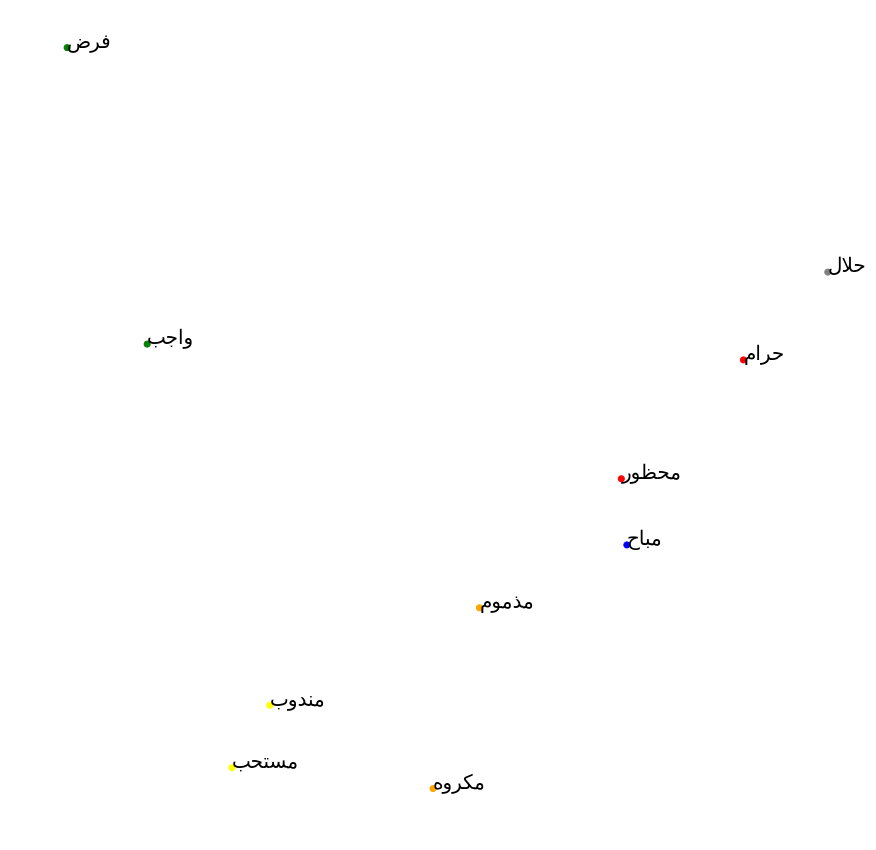

In [97]:
word_list = ['محظور', # forbidden
            'حرام', # forbidden
            'مكروه', # discouraged
            'مذموم', # discouraged
            'مباح', # neutral
            'مندوب', # recommended
            'مستحب', # recommended
            'واجب', # obligatory
            'فرض', # obligatory
            'حلال'] # allowed
colors = ['red', 'red', 'orange', 'orange', 'blue', 'yellow', 'yellow', 'green', 'green', 'grey']
model = models['Stemmed Fiqh']
plot_embedding(word_list, model, method='pca', colors=colors, learning_rate=5)